# Visually differentiating PCA and Linear Regression

I've always been fascinated by the concept of PCA. Considering its wide range of applications and how inherently mathematical the idea is, I feel PCA is one of the pillars of the intersection between Pure Mathematics and Real-world analytics. Besides, the fact that you could think about real data as just raw numbers and then transform it down to something you can visualize and relate to, is extremely powerful and essential in any learning process.

Just in case you're wondering, Principle Component Analysis (PCA) simply put is a dimensionality reduction technique that can find the combinations of variables that explain the most variance. So you can transform a 1000-feature dataset into 2D so you can visualize it in a plot or you could bring it down to x features where x << 1000 while preserving most of the variance in the data. I've previously explored Facial image compression and reconstruction using PCA using scikit-learn.

In this post I would like to delve into the concept of linearity in Principal Component Analysis. To quote wiki for a more detail definition of PCA:

Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components

The concept that I would like to explore is how different this is from Linear Regression. With Linear Regression, we are trying to find a straight line that best fits the data. So if we took a very simple example of univariate regression, predicting one variable with another, how would my PCA transformation look from the best-fit line derived through linear regression.

Let's dive in and find out.

In [11]:
#Importing required Python packages 
import matplotlib.pylab as plt 
import numpy as np 
from sklearn.decomposition import PCA 
from sklearn.linear_model import LinearRegression 
from pprint import pprint 
import seaborn as sns 
from matplotlib import collections as mc 
%matplotlib inline 

np.random.seed(sum(map(ord, "aesthetics"))) 
sns.set_context('notebook') 
sns.set_style('darkgrid') 
plt.rcParams['figure.figsize'] = (16, 5)

In [12]:
# Univariate Linear Regression Let's define a random x and y and try to regress y with x, denoted as y~x.

#Define a simple range of values for x and reshape so sklearn likes it. 
x=np.array(range(1,100)) 
x=x[:, np.newaxis] 

#Define y as a function of X and introduce some noise so we get nice plots. 
y=10+2*x.ravel() 
y=y+np.random.normal(loc=0, scale=70, size=99)

In [13]:
# Let's now fit a Linear Regression model to x and y. We will use sklearn's Linear models and do a simple fit+predict.

#Instantiate, fit and predict y~x 
lin=LinearRegression() 
lin.fit(x,y) 
y_pred=lin.predict(x)

In [14]:
# Great, we will not plot this so we can visualize the best-fit straight line that sklearn has determined for y~x.

def plotline(x1,y1,x2,y2,c,l): 
    plt.scatter(x1, y1, color='black') 
    plt.plot(x2, y2, color=c, linewidth=l) 
    plt.axis('tight') 
    plt.xlabel('x') 
    plt.ylabel('y') 
    sns.despine(offset=10, trim=True)

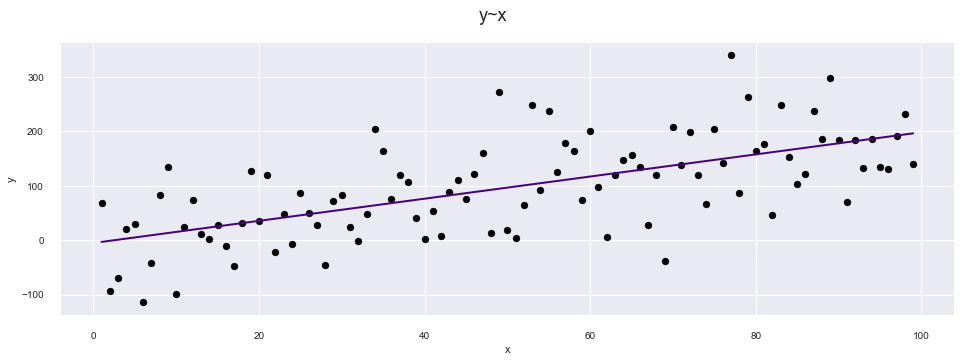

In [15]:
plotline(x,y,x,y_pred,'indigo',2) 
plt.suptitle('y~x',fontsize=18) 
plt.show()

In [16]:
#OK, now before we attempt to do anything with PCA, I am curious if there's a difference between y~x and x~y. What happens if we change sides?
#Let's find out.

#Reshape y so sklearn doesn't cry foul 
y=y[:,np.newaxis] 
#Instantiate, fit and predict x~y 
lin=LinearRegression() 
lin.fit(y,x) 
x_pred=lin.predict(y)

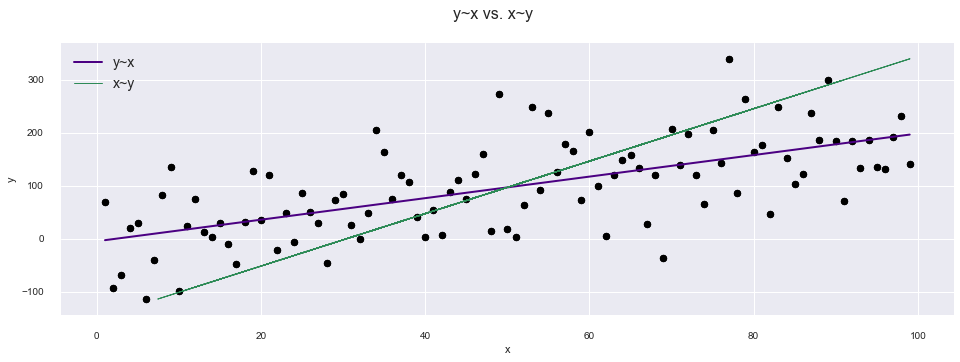

In [17]:
#Notice the variable names here. y_pred is the regressed value of y based on x while x_pred is the regressed value of x based on y. Let's now plot this line as well on the same plot and compare real-time. 

def onevstwo():
    plotline(x,y,x,y_pred,'indigo',2)
    plotline(x,y,x_pred,y,'seagreen',1)
    plt.suptitle('y~x vs. x~y',fontsize=16)
    plt.legend(['y~x','x~y'], loc='best', fontsize=14)

onevstwo()
plt.show()

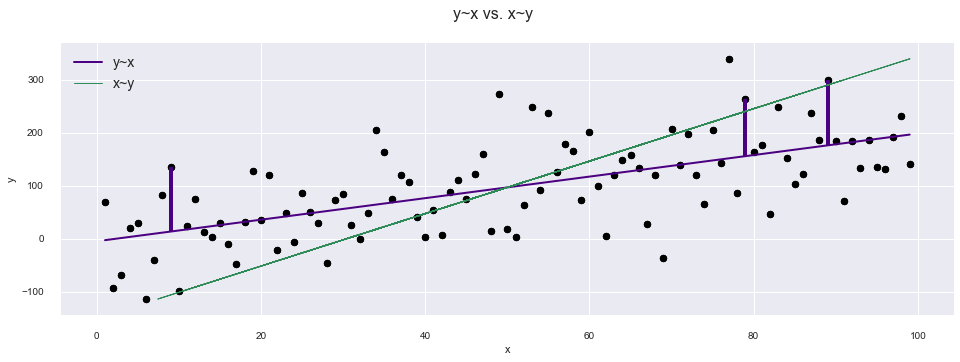

In [18]:
#Ah! Look at the difference there. These are definitely not the same. But why are they different? Let's try to plot what each of them are trying to minimize. The metric we've used for linear regression (default) is Ordinary Least Squares.

#We will plot the difference between the actual value of y and the predicted value for a few samples and see where they land. Note that I am trying to find some good ones for plotting below by looking at how large the difference is.

#Let's flatten our arrays so it's easier to plot
x,x_pred,y,y_pred=x.ravel(),x_pred.ravel(),y.ravel(),y_pred.ravel()

#Grab some indices where the difference between y and y_pred is the greatest.
indices=np.argsort(y-y_pred)[-8:-5]

#Plot some sample y-ypred in the earlier plot
onevstwo()
lines=[[(x[i],y[i]), (x[i],y_pred[i])] for i in indices]
lines=mc.LineCollection(lines, colors='indigo', linewidths=4)
plt.gca().add_collection(lines)
plt.show()

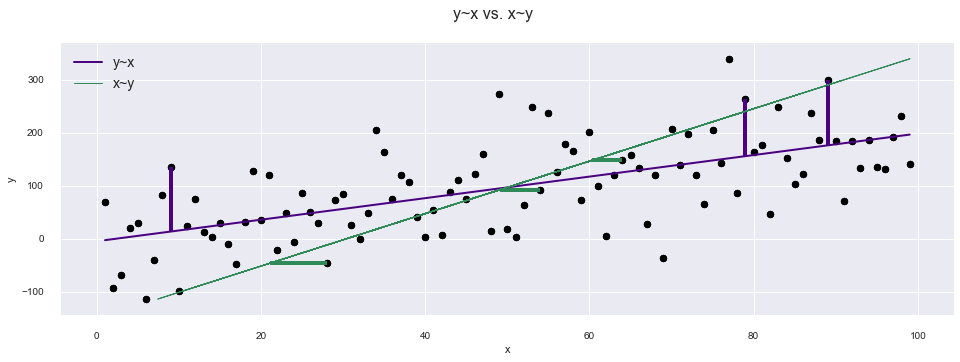

In [19]:
#That makes it clear. When we regress y~x, it is the vertical distances that are minimized based on the Least Squares method (or the metric we choose). This is highlighted in the brown lines in the plot above.

#So what happens when we regress x~y? Let's plot this as well though it's easy to guess what happens.


#Grab some indices where the difference between x and x_pred is the greatest. 
indices_r=np.argsort(x-x_pred)[-40:-37] 

#Plot some sample y-y_pred in the earlier plot 
onevstwo() 
lines=[[(x[i],y[i]), (x[i],y_pred[i])] for i in indices] 
lines=mc.LineCollection(lines, colors='indigo', linewidths=4) 
plt.gca().add_collection(lines) 

#Plot some sample x-x_pred as well 
lines=[[(x[i],y[i]), (x_pred[i],y[i])] for i in indices_r] 
lines=mc.LineCollection(lines, colors='seagreen', linewidths=4) 
plt.gca().add_collection(lines) 
plt.show() 

There is the confirmation. When we regress x~y instead of y~x, the model tries to minimize the horizontal distances rather than the vertical distances using OLS.

Awesome! We're now fully geared up to understand how PCA differs from this.

Let's go ahead and fit a PCA model to our dataset.

PCA vs Linear Regression
We need to combine x and y so we can run PCA. Let's then fit a PCA model to the dataset.

In [20]:
#Combine x and y 
xy=np.array([x,y]).T

After instantiating a PCA model, we will firstly fit and transform PCA with n_components = 1 to our dataset. This will run PCA and determine the first (and only) principal component.

We will then do an inverse transform on the resulting compressed array so we can project onto our plots for comparison. If you don't fully understand what's going on here, I suggest you take a look at one of my earlier posts here where I dig into PCA in detail and demonstrate dimensionality reduction.

In [21]:
#Instantiate a PCA model, the run fit_transform to xy followed by inverse_transform 
pca=PCA(n_components=1) 
xy_pca=pca.fit_transform(xy) 
xy_n=pca.inverse_transform(xy_pca)

Great, we now have the datasets we need to plot. xy, which is nothing but x and y put together and xy_n, which we got by inverse transformation of the PCA results. If we plot these two together like we did for Linear Regression, things will be clear as to what is being minimized.

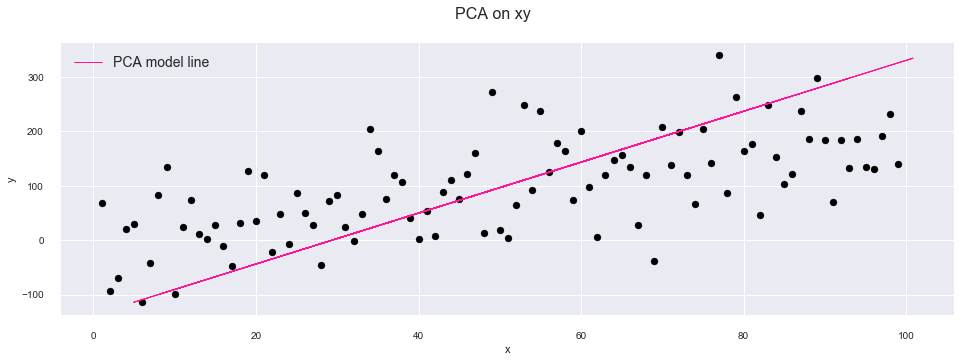

In [22]:
#Plot xy against xy_n. Note that we're simply passing x and y to the function since xy=x+y. 
plotline(x,y,xy_n[:,0],xy_n[:,1],'deeppink',1) 
plt.suptitle('PCA on xy',fontsize=16) 
plt.legend(['PCA model line'], loc='best', fontsize=14) 
plt.show() 

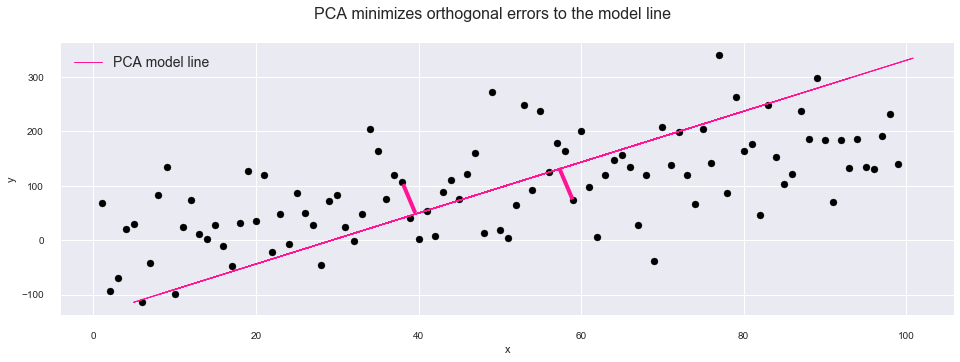

In [23]:
#There it is, this actually looks quite similar to the first regression we plotted for y~x. For now, can we try to find out what is being minimized? 

#Replot the PCA line so we can examine 
plotline(x,y,xy_n[:,0],xy_n[:,1],'deeppink',1) 
#Plot some sample values to demonstrate PCA 
lines=[[(38.1, 102.9), (39.6,50)], [(58.95,75), (57.3, 133)]] 
lines=mc.LineCollection(lines, colors='deeppink', linewidths=4) 
plt.gca().add_collection(lines) 
plt.suptitle('PCA minimizes orthogonal errors to the model line',fontsize=16) 
plt.legend(['PCA model line'], loc='best', fontsize=14) 
plt.show() 

So PCA also tries to find a best fit line through the data points but it minimizes the orthogonal distance to the model line where as Linear Regression minimizes distance from the perspective of the axis you're regressing with respect to.

I guess in rudimentary terms we can think of the model line as sort of a third axis against which we're regressing our other variables x and y. Hope the plot illustrates the concept clearly. Note that I hand picked couple of data points to illustrate the orthogonality. This plot will only work obviously for the data we're using in this exercise :-)

Putting it all together
So let's plot all three model lines we've generated so far together and compare them one last time.

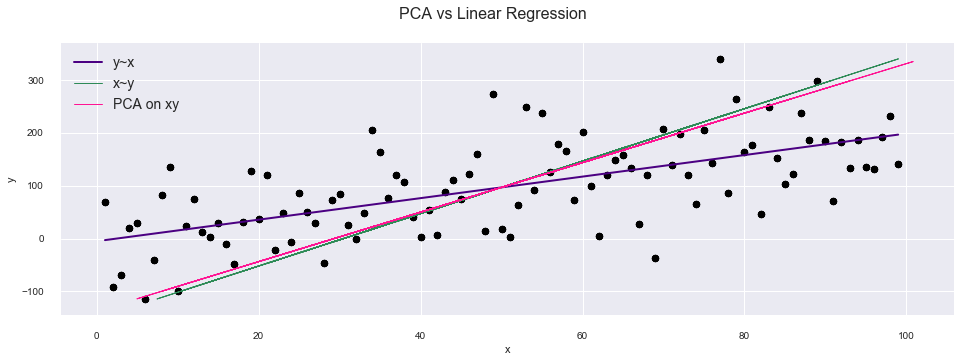

In [24]:
#Plot y~x vs x~y 
onevstwo() 

#Plot PCA model lines 
plotline(x,y,xy_n[:,0],xy_n[:,1],'deeppink',1) 
plt.suptitle('PCA vs Linear Regression',fontsize=16) 
plt.legend(['y~x', 'x~y', 'PCA on xy'], loc='best', fontsize=14) 
plt.show()

As we can see, the PCA model line and x~y lines are fairly close to each other but we can tell that they're not the same. This is primarily because of how well we've distributed the sample data horizontally w.r.t the x axis.

So that brings us to a close. Hopefully that was helpful to some of you reading. As always, let me know your feedback and if you have any questions. Cheers!